# Project 2 - Classification

<h5 style="font-size: 1.3em;color: #69956e;"> Predict customers likely to respond to a marketing campaign</h5>
<p>This notebook uses the <em>campaign.xlsx</em> dataset.</p>

<strong>Machine Learning for Marketing 2023/2024</strong>

<strong>Professors:</strong>
- Nuno António
- Ana Edmundo
- Hugo Silva
- Vasco Jesus

<strong>Projet developed by:</strong>
- Anabela Florência, r20201584
- António Cadaixa, r20201505
- Constança Rodrigues, r20201586
- Joana Pimenta, r20201590
- Laura Freitas, 20230172
<br>

<h5 style="font-size: 1.3em; color: #69956e;">Work Description</h5>

<p style="color: #000000;"> This document aims to further explore the needs of the Marketing Department of a retail company for predicting which customers are likely to respond to a marketing campaing based on information from a previous campaign. A response model can provide a significant boost to the efficiency of a marketing campaign by increasing responses or reducing expenses.</p>

# Initializations and Data Loading

In [41]:
# Load packages
import os
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy.stats import pointbiserialr
from datetime import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats.mstats import winsorize
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer, StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import collections 
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report, precision_recall_curve
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LogisticRegression,Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from feature_engine.creation import CyclicalFeatures
from yellowbrick.model_selection import RFECV, LearningCurve
from yellowbrick.classifier import ROCAUC, ClassificationReport,PrecisionRecallCurve
from sklearn import metrics
from sklearn import tree
from sklearn import linear_model
from sklearn.preprocessing import SplineTransformer
from sklearn.impute import KNNImputer
from yellowbrick.regressor import ResidualsPlot, PredictionError



# Ensure this line is not indented beyond the expected level
get_ipython().system('pip install category_encoders')
import category_encoders as ce
import pickle
# import graphviz
!pip install graphviz
from numpy.polynomial.polynomial import Polynomial
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

# To plot in notebook
%matplotlib inline

In [42]:
# Load the dataset 
ds = pd.read_excel('campaign_prepared.xlsx') 

# Data Understanding

In [43]:
# Display the top 10 rows - provides an overview of the varibles and facilitates data understanding
ds.head(10)

,ID,Education,Marital_Status,NumDealsPurchases,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,...,MntGoldProds_log,Age,MntFood_log,Total_Children,Total_Campaigns,Engagement_Score,AOV,R_score,RFM_Score,RFM_Label
0,0,Graduation,Married,1,0,0,0,0,0,0,...,4.007333,39,18.735464,0,0,0.285714,1.660202,2,10,Big Spenders
1,1,Graduation,Single,1,0,0,0,0,1,0,...,3.637586,63,8.738735,0,1,1.142857,1.028798,5,12,Recent Customers
2,9,Master,Single,4,0,0,0,0,0,0,...,3.610918,49,5.411646,2,0,1.714286,1.189364,1,5,At Risk
3,13,PhD,Widow,2,0,0,0,0,0,0,...,2.197225,77,3.871201,1,0,1.142857,1.510693,3,5,Other
4,17,PhD,Married,4,0,0,0,0,0,0,...,4.343805,53,14.904153,1,0,1.285714,0.952085,1,10,Frequent Customers
5,20,2n Cycle,Married,1,0,0,0,0,0,0,...,4.127134,59,11.916789,1,0,0.714286,2.478514,1,6,Other
6,22,Graduation,Divorced,2,0,0,0,0,0,0,...,2.708050,48,10.151597,1,0,1.428571,1.291814,1,7,Other
7,24,Master,Together,5,0,0,0,0,0,0,...,1.945910,64,5.886104,2,0,1.714286,0.898038,1,5,Other
8,25,Graduation,Married,2,0,0,0,0,0,0,...,5.036953,66,15.722201,1,0,0.857143,1.280598,5,13,Loyal Customers
9,35,Graduation,Married,3,0,0,0,0,0,0,...,4.454347,37,10.265697,1,0,1.428571,1.821655,4,9,Emerging Customers


In [44]:
# More detailed information about the DataFrame and the variables
# Helps understanding the existing types of data and the amount of non-null entries of each variable

def basic_info(ds):
    print("This dataset has ", ds.shape[1], " columns and ", ds.shape[0], " rows.")
    print("This dataset has ", ds[ds.duplicated()].shape[0], " duplicated rows.")
    print(" ")
    print("Information about this dataset: ")
    print(" ")
    print(ds.info())
basic_info(ds)

This dataset has  22  columns and  2230  rows.
This dataset has  0  duplicated rows.
 
Information about this dataset: 
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2230 entries, 0 to 2229
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 2230 non-null   int64  
 1   Education          2230 non-null   object 
 2   Marital_Status     2230 non-null   object 
 3   NumDealsPurchases  2230 non-null   int64  
 4   AcceptedCmp3       2230 non-null   int64  
 5   AcceptedCmp4       2230 non-null   int64  
 6   AcceptedCmp5       2230 non-null   int64  
 7   AcceptedCmp1       2230 non-null   int64  
 8   AcceptedCmp2       2230 non-null   int64  
 9   Complain           2230 non-null   int64  
 10  Response           2230 non-null   int64  
 11  MntWines_log       2230 non-null   float64
 12  MntGoldProds_log   2230 non-null   float64
 13  Age                2230 non-null   int64  
 14

### Conclusion
- The dataset has 44 columns and 2230 observations, without any null values

## Summary Statistics Analysis

In [45]:
# Summary statistics for all variables to better understand them and check if there's any inconsistencies 
ds.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,2230.0,NaN,NaN,NaN,5585.102242,3241.680707,0.0,2826.75,5453.5,8417.5,11191.0
Education,2230,5,Graduation,1122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital_Status,2230,5,Married,866,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NumDealsPurchases,2230.0,NaN,NaN,NaN,2.220628,1.537836,0.0,1.0,2.0,3.0,6.0
AcceptedCmp3,2230.0,NaN,NaN,NaN,0.073094,0.260349,0.0,0.0,0.0,0.0,1.0
AcceptedCmp4,2230.0,NaN,NaN,NaN,0.074888,0.263269,0.0,0.0,0.0,0.0,1.0
AcceptedCmp5,2230.0,NaN,NaN,NaN,0.072646,0.259612,0.0,0.0,0.0,0.0,1.0
AcceptedCmp1,2230.0,NaN,NaN,NaN,0.064574,0.245828,0.0,0.0,0.0,0.0,1.0
AcceptedCmp2,2230.0,NaN,NaN,NaN,0.013453,0.11523,0.0,0.0,0.0,0.0,1.0
Complain,2230.0,NaN,NaN,NaN,0.008969,0.094298,0.0,0.0,0.0,0.0,1.0


In [46]:
# Create a copy of the original dataset to ensure that all subsequent changes are made on the duplicated dataset
X = ds.copy(deep=True)

In [47]:
# Set the color palette
my_palette = sns.diverging_palette(20, 220, n=200)
color1 = my_palette[199]
color2 = my_palette[150]
color3 = my_palette[100]
color4 = my_palette[50]
color5 = my_palette[1]
campaign_colors = [color1, color2, color3, color4, color5]

# Data Preparation

## Feature Enconding

In [48]:
# Label encoding assigns a unique integer to each category in categorical variables ('Education', 'Marital_Status' and 'RFM_Label'
# It's more compact than one-hot encoding because it doesn't create additional columns, and that's why we chose to use it

# Initialize the label encoder
le = LabelEncoder()

# Apply label encoding to 'Education'
X['Education'] = le.fit_transform(X['Education'])

# Apply label encoding to 'Marital_Status'
X['Marital_Status'] = le.fit_transform(X['Marital_Status'])

# Apply label encoding to 'RFM_Label'
X['RFM_Label'] = le.fit_transform(X['RFM_Label'])

In [49]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2230 entries, 0 to 2229
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 2230 non-null   int64  
 1   Education          2230 non-null   int32  
 2   Marital_Status     2230 non-null   int32  
 3   NumDealsPurchases  2230 non-null   int64  
 4   AcceptedCmp3       2230 non-null   int64  
 5   AcceptedCmp4       2230 non-null   int64  
 6   AcceptedCmp5       2230 non-null   int64  
 7   AcceptedCmp1       2230 non-null   int64  
 8   AcceptedCmp2       2230 non-null   int64  
 9   Complain           2230 non-null   int64  
 10  Response           2230 non-null   int64  
 11  MntWines_log       2230 non-null   float64
 12  MntGoldProds_log   2230 non-null   float64
 13  Age                2230 non-null   int64  
 14  MntFood_log        2230 non-null   float64
 15  Total_Children     2230 non-null   int64  
 16  Total_Campaigns    2230 

## Feature Scaling

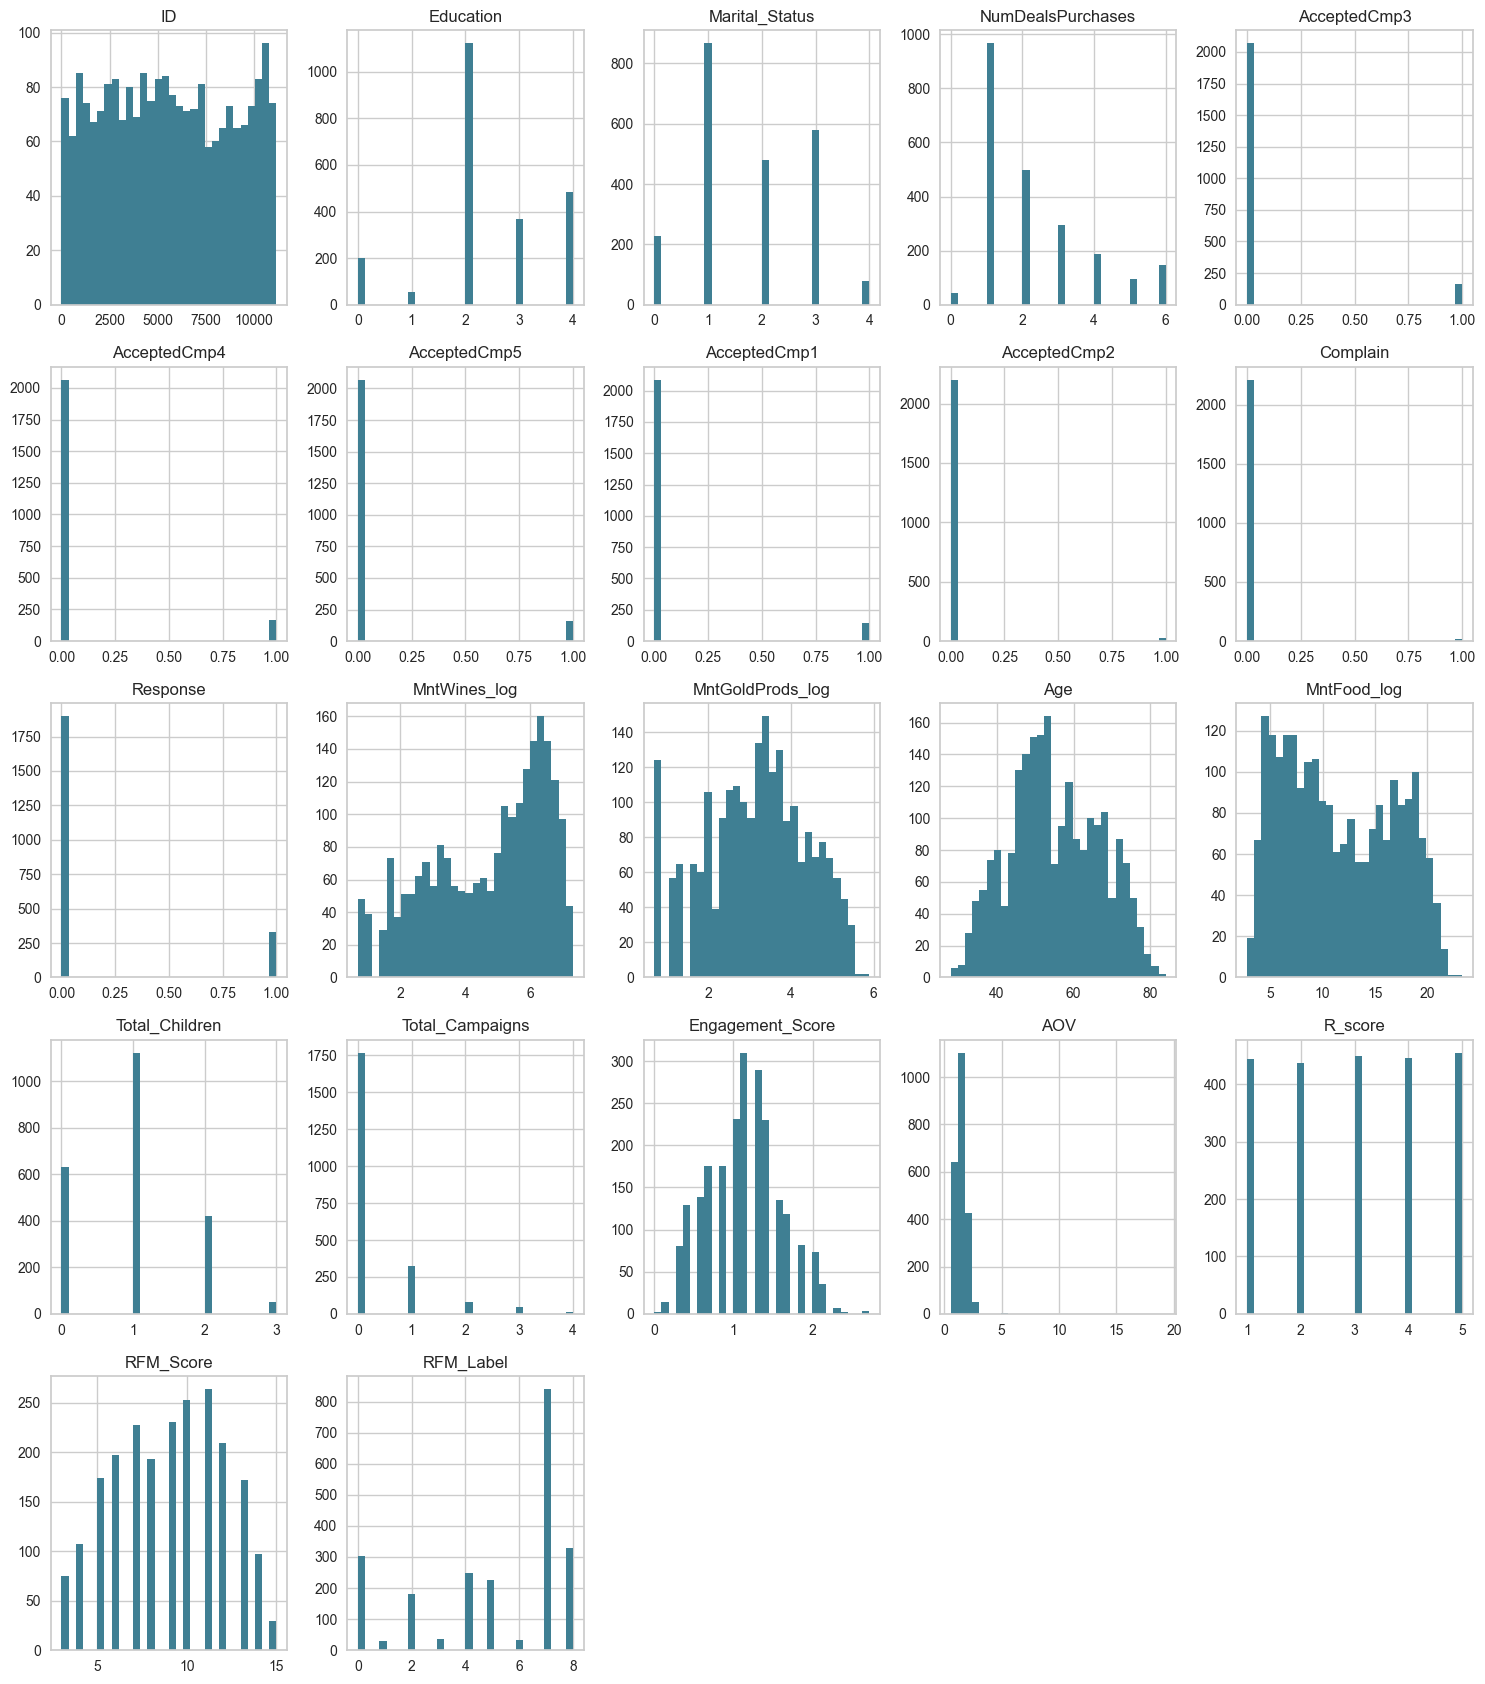

In [50]:
# Plot the distribution of each variable

X.hist(figsize=(15, 17), bins=30, color=color1)
plt.tight_layout()
plt.show()

In [51]:
# Normal Distribution -> Features that are approximately normally distributed can be scaled using StandardScaler
# Skewed Distribution -> For features that are heavily skewed, a Log Transformation can be applied before scaling, or MinMaxScaler can be used to normalize the values to a specific range
# Binary Features -> Features that are binary do not require scaling
# Multimodal Distribution -> Features with multiple peaks might benefit from trobust scaling techniques

# Define lists for StandardScaler and MinMaxScaler based on visual inspection
standard_scaling_features = ['NumDealsPurchases', 'MntWines_log', 'MntGoldProds_log', 'MntFood_log']
minmax_scaling_features = ['Education', 'Marital_Status', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Age', 'Total_Children', 'Total_Campaigns', 'Engagement_Score', 'AOV', 'R_score', 'RFM_Score', 'RFM_Label']

In [52]:
# Apply Standard Scaling

scaler_standard = StandardScaler()
X = X.copy()
X[standard_scaling_features] = scaler_standard.fit_transform(X[standard_scaling_features])

In [53]:
# Apply MinMax Scaling

scaler_minmax = MinMaxScaler()
X[minmax_scaling_features] = scaler_minmax.fit_transform(X[minmax_scaling_features])

In [54]:
X.head()

,ID,Education,Marital_Status,NumDealsPurchases,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,...,MntGoldProds_log,Age,MntFood_log,Total_Children,Total_Campaigns,Engagement_Score,AOV,R_score,RFM_Score,RFM_Label
0,0,0.50,0.25,-0.793909,0.0,0.0,0.0,0.0,0.0,0.0,...,0.688513,0.196429,1.379447,0.000000,0.00,0.105263,0.058889,0.25,0.583333,0.250
1,1,0.50,0.50,-0.793909,0.0,0.0,0.0,0.0,1.0,0.0,...,0.386373,0.625000,-0.534509,0.000000,0.25,0.421053,0.025179,1.00,0.750000,1.000
2,9,0.75,0.50,1.157322,0.0,0.0,0.0,0.0,0.0,0.0,...,0.364581,0.375000,-1.171508,0.666667,0.00,0.631579,0.033752,0.00,0.166667,0.000
3,13,1.00,1.00,-0.143499,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.790620,0.875000,-1.466439,0.333333,0.00,0.421053,0.050907,0.50,0.166667,0.875
4,17,1.00,0.25,1.157322,0.0,0.0,0.0,0.0,0.0,0.0,...,0.963461,0.446429,0.645911,0.333333,0.00,0.473684,0.021084,0.00,0.583333,0.500


In [55]:
X.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
ID,2230.0,5.585102e+03,3241.680707,0.000000,2826.750000,5453.500000,8417.500000,11191.000000
Education,2230.0,5.991031e-01,0.280676,0.000000,0.500000,0.500000,0.750000,1.000000
Marital_Status,2230.0,4.338565e-01,0.265180,0.000000,0.250000,0.500000,0.750000,1.000000
NumDealsPurchases,2230.0,1.011647e-16,1.000224,-1.444319,-0.793909,-0.143499,0.506912,2.458142
AcceptedCmp3,2230.0,7.309417e-02,0.260349,0.000000,0.000000,0.000000,0.000000,1.000000
AcceptedCmp4,2230.0,7.488789e-02,0.263269,0.000000,0.000000,0.000000,0.000000,1.000000
AcceptedCmp5,2230.0,7.264574e-02,0.259612,0.000000,0.000000,0.000000,0.000000,1.000000
AcceptedCmp1,2230.0,6.457399e-02,0.245828,0.000000,0.000000,0.000000,0.000000,1.000000
AcceptedCmp2,2230.0,1.345291e-02,0.115230,0.000000,0.000000,0.000000,0.000000,1.000000
Complain,2230.0,8.968610e-03,0.094298,0.000000,0.000000,0.000000,0.000000,1.000000


In [56]:
# Standard and MinMax Scaling methods have been applied appropriately to the respective features
# Note: It's fine to have negative values as this is a result of centering the data around the mean and scaling to unit variance

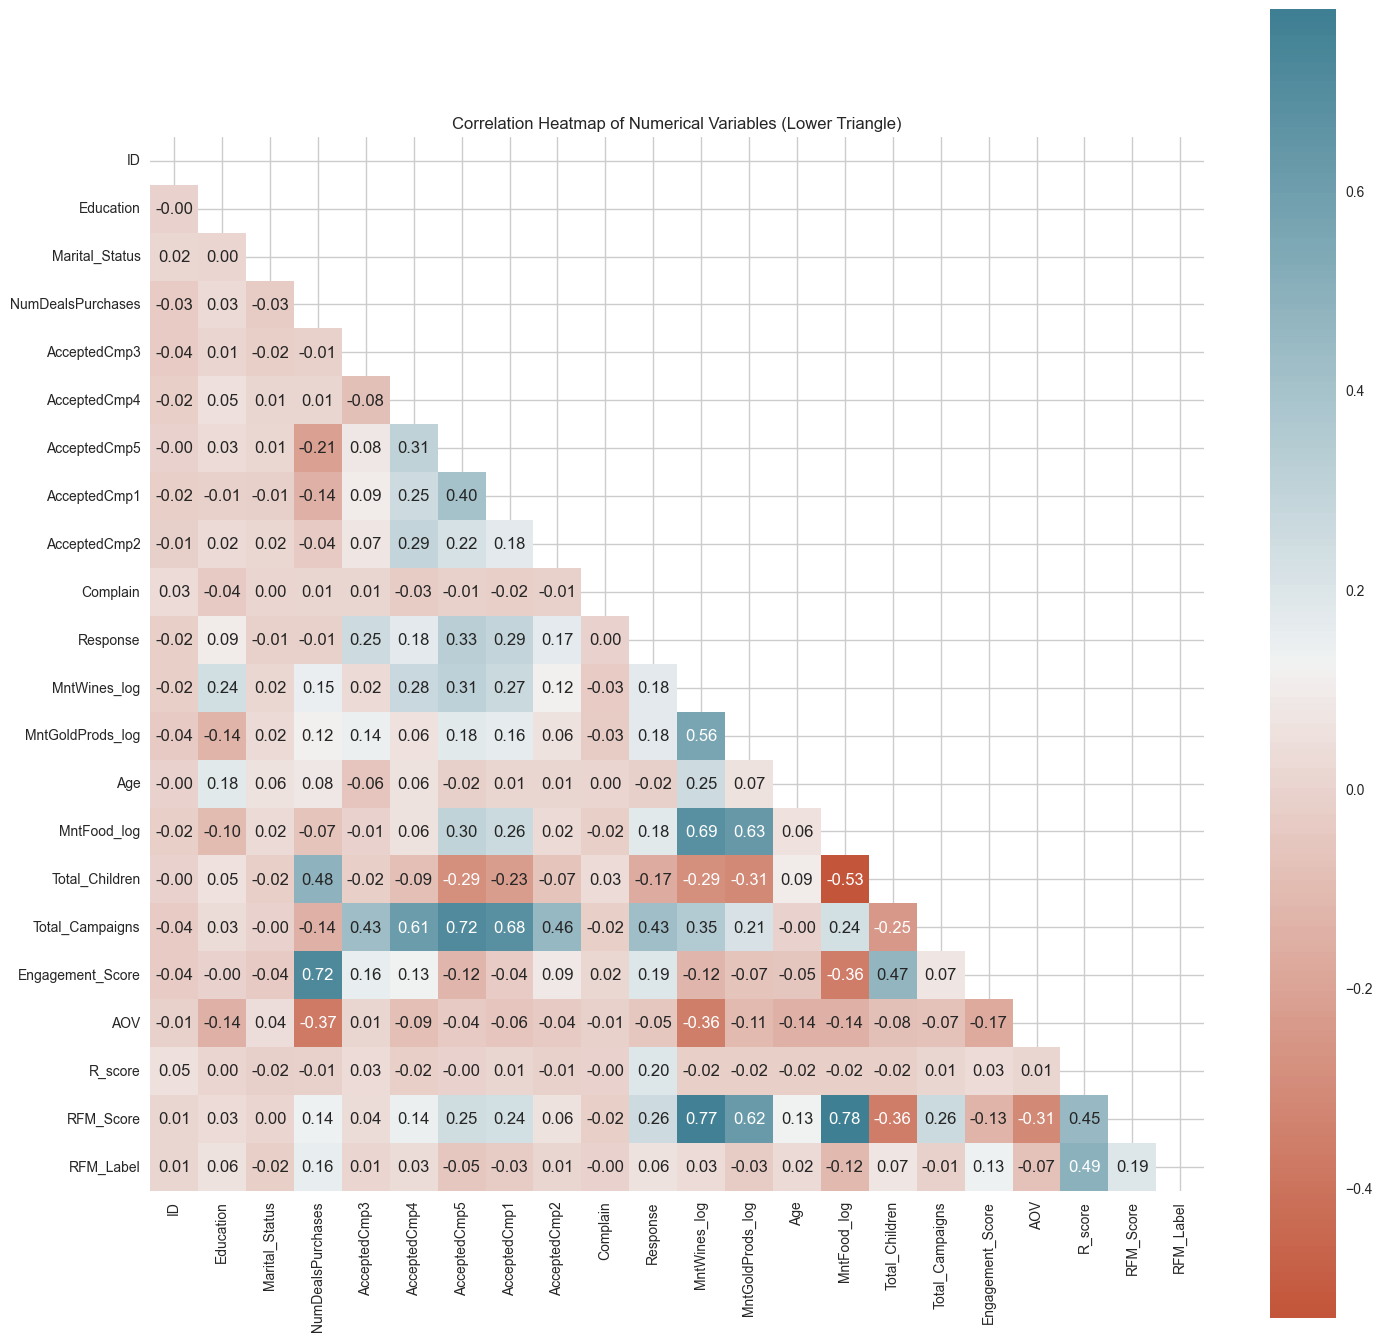

In [57]:
# Visualize the correlation matrix as a heatmap to easily identify relationships between numerical variables

# Select only the numerical columns
numerical_X = X.select_dtypes(include=['float64', 'int64', 'int32'])

# Compute the correlation matrix
corr_matrix = numerical_X.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

my_palette = sns.diverging_palette(20, 220, n=200)

# Create a heatmap
plt.figure(figsize=(17, 17))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap=my_palette, fmt=".2f", cbar=True, square=True)
plt.title('Correlation Heatmap of Numerical Variables (Lower Triangle)')
plt.show()

## Feature Selection

In [58]:
# Create the target
y = X['Response']

In [59]:
X = X.drop(columns=['Response'])
X = X.drop(columns=['ID'])

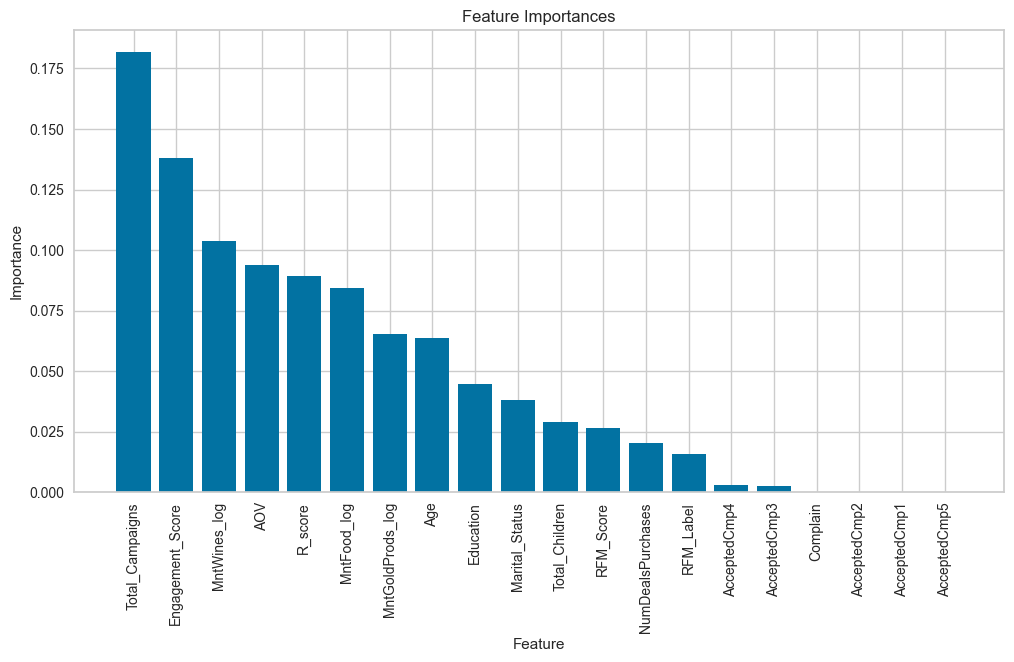

In [60]:
# Feature Selection using Decision Tree

dt = DecisionTreeClassifier()
dt.fit(X, y)

# Get feature importances
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

# Review Feature Importances: Identify the top features based on their importance scores.
# Refine the Feature Set: Optionally, you can refine the feature set by selecting a subset of the most important features.

In [61]:
#Removing the variables with less importance
X = X.drop(columns=['Complain'])
X = X.drop(columns=['AcceptedCmp2'])
X = X.drop(columns=['AcceptedCmp1'])

# Modeling

## Logistic Regression

In [62]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=123)

Counter({0.0: 1422, 1.0: 250})


<Axes: xlabel='y', ylabel='count'>

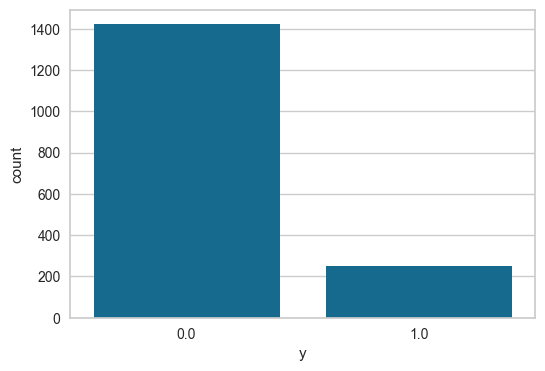

In [63]:
# Display target balance in the training dataset
print(collections.Counter(y_train))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="y", data=pd.DataFrame(data={'y':y_train}), ax=ax)

Counter({0.0: 1422, 1.0: 1422})


<Axes: xlabel='y', ylabel='count'>

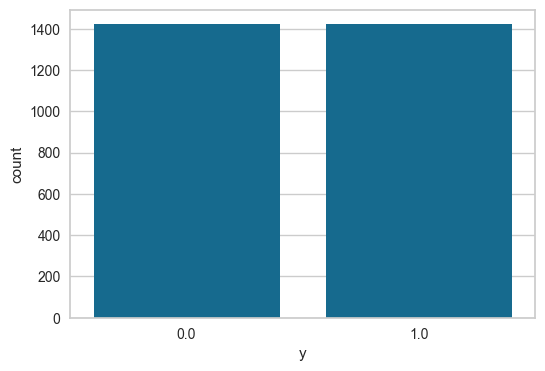

In [64]:
# Applyting SMOTE to generate new instances (oversampling)
sm = SMOTE(random_state=123, sampling_strategy=1.0)
X_train, y_train = sm.fit_resample(X_train, y_train)

# Display target balance in the training dataset
print(collections.Counter(y_train))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="y", data=pd.DataFrame(data={'y':y_train2}), ax=ax)

#### Model training

In [65]:
# Define a function to evaluate model performance such as Accuracy, Precision, Recall, F1 Score, and AUC-ROC for further use
def evaluate_model(y_test, y_pred, y_pred_proba):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'AUC-ROC: {auc_roc:.4f}')
    return accuracy, precision, recall, f1, auc_roc

In [66]:
# Using Grid Search for Logistic Regression for tunning
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_lr = grid_search.best_estimator_

In [67]:
# Obtain metrics from the best Logistic Regression model
y_pred_train = best_lr.predict(X_train)
y_pred_test = best_lr.predict(X_test)
y_pred_proba_train = best_lr.predict_proba(X_train)
y_pred_proba_test = best_lr.predict_proba(X_test)

print("Best Logistic Regression Parameters:")
print(grid_search.best_params_)

Best Logistic Regression Parameters:
{'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [68]:
print("Best Logistic Regression Performance on Test Set:")
evaluate_model(y_test, y_pred_test, y_pred_proba_test)

Best Logistic Regression Performance on Test Set:
Accuracy: 0.8262
Precision: 0.4539
Recall: 0.8313
F1 Score: 0.5872
AUC-ROC: 0.9096


(0.8261648745519713,
 0.45394736842105265,
 0.8313253012048193,
 0.5872340425531914,
 0.9095751426759671)

The Logistic Regression model correctly predicts 82.62% of the test samples (accuracy). Out of all the positive predictions, 45.39% were actually positive (precision). Additionally, out of all the actual positive samples, the model correctly identified 83.13% (recall). The F1 Score, which achieves a good balance between precision and recall, is 0.5872.
Regarding AUC-ROC, with a value of 0.9095, we can conclude that the model has a strong ability to distinguish between classes due to its high score.
<br><br>

In [69]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

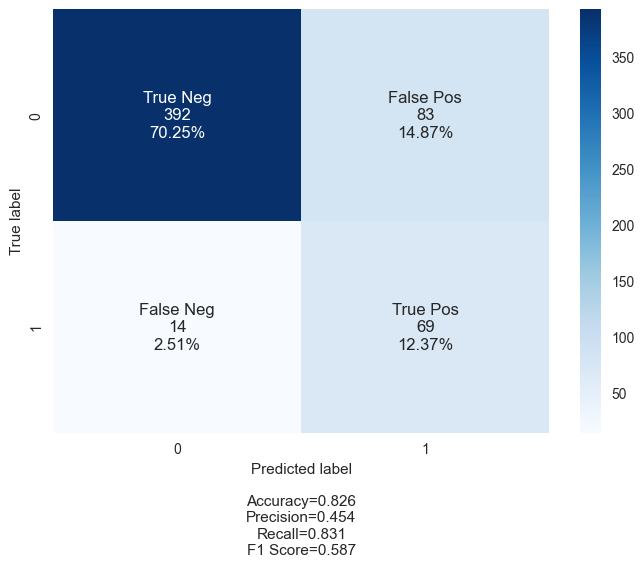

In [70]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

- **High True Negative Rate:** The model is effective at correctly identifying instances where the condition is not present, as indicated by the high number of true negatives (392), which account for 70.25% of the total predictions.

- **Moderate True Positive Rate:** The model correctly identifies a portion of the instances where the condition is present, shown by the true positives (69), which make up 12.37% of the total predictions. There is room for improvement here.

- **False Positives and Negatives:** There are 83 false positives (14.87%), where the model incorrectly predicted the condition's presence, and 14 false negatives (2.51%), where the model missed predicting the condition. These errors indicate that the model has some misclassifications in both directions.

Overall, the model demonstrates strong performance in correctly identifying true negatives and has a high recall, but it suffers from lower precision due to a significant number of false positives. The accuracy and F1 score indicate that while the model is generally reliable, there is potential for improvement in precision to reduce the number of false positive predictions

In [71]:
# Print the values of TP, TN, FP, FN
tn, fp, fn, tp = cf.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 392
False Positives: 83
False Negatives: 14
True Positives: 69


In [72]:
# Define a function to create a dataframe with metrics
def performanceMetricsDF(metricsObj, y_train, y_pred_train, y_test, y_pred_test):
    measures_list = ['ACCURACY', 'PRECISION', 'RECALL', 'F1 SCORE', 'AUC']
    train_results = [metricsObj.accuracy_score(y_train, y_pred_train),
                     metricsObj.precision_score(y_train, y_pred_train),
                     metricsObj.recall_score(y_train, y_pred_train),
                     metricsObj.f1_score(y_train, y_pred_train),
                     metricsObj.roc_auc_score(y_train, y_pred_train)]
    test_results = [metricsObj.accuracy_score(y_test, y_pred_test),
                    metricsObj.precision_score(y_test, y_pred_test),
                    metricsObj.recall_score(y_test, y_pred_test),
                    metricsObj.f1_score(y_test, y_pred_test),
                    metricsObj.roc_auc_score(y_test, y_pred_test)]
    resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test': test_results})
    return resultsDF

# Call the performanceMetricsDF function with the correct variables
resultsDF_lr = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
print(resultsDF_lr)

     Measure     Train      Test
0   ACCURACY  0.832278  0.826165
1  PRECISION  0.832512  0.453947
2     RECALL  0.831927  0.831325
3   F1 SCORE  0.832219  0.587234
4        AUC  0.832278  0.828294


In [73]:
# After some iterations and realizing the overfitting it was decided to implement Ridge regularization to reduce overfitting

# Define the parameter grid for C values
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]  # Try a wide range of C values
}

# Create a GridSearchCV object with Logistic Regression and the parameter grid
grid_search_ridge = GridSearchCV(LogisticRegression(penalty='l2', solver='liblinear'), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_ridge.fit(X_train, y_train)

# Get the best estimator (Logistic Regression with the best C value)
best_ridge = grid_search_ridge.best_estimator_

# Print the best C value
print("Best parameters for Logistic Regression with Ridge Regularization:")
print(grid_search_ridge.best_params_)

# Obtain metrics from the best Logistic Regression model with Ridge Regularization
y_pred_train_ridge = best_ridge.predict(X_train)
y_pred_test_ridge = best_ridge.predict(X_test)
y_pred_proba_train_ridge = best_ridge.predict_proba(X_train)
y_pred_proba_test_ridge = best_ridge.predict_proba(X_test)

# Call the performanceMetricsDF function with the correct variables
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train_ridge, y_test, y_pred_test_ridge)
print(resultsDF)

print("Best Logistic Regression with Ridge Regularization Performance on Test Set:")
evaluate_model(y_test, y_pred_test_ridge, y_pred_proba_test_ridge)

Best parameters for Logistic Regression with Ridge Regularization:
{'C': 100}
     Measure     Train      Test
0   ACCURACY  0.832278  0.826165
1  PRECISION  0.832512  0.453947
2     RECALL  0.831927  0.831325
3   F1 SCORE  0.832219  0.587234
4        AUC  0.832278  0.828294
Best Logistic Regression with Ridge Regularization Performance on Test Set:
Accuracy: 0.8262
Precision: 0.4539
Recall: 0.8313
F1 Score: 0.5872
AUC-ROC: 0.9096


(0.8261648745519713,
 0.45394736842105265,
 0.8313253012048193,
 0.5872340425531914,
 0.9095751426759671)

the Ridge regularization with the optimized C value (100) has slightly improved most metrics except AUC-ROC, which saw a notable decrease. Thus, we keep this Regularization, considering that the model benefits from regularization to reduce overfitting.
<br><br>

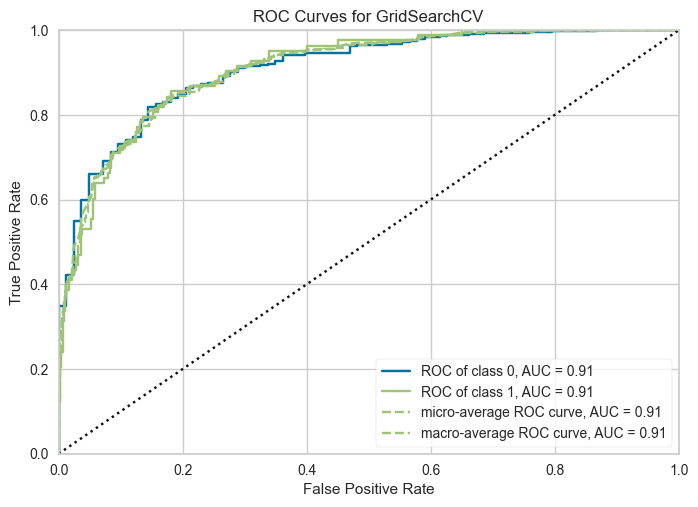

<Axes: title={'center': 'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [74]:
visualizer = ROCAUC(grid_search_ridge, classes=['0', '1'])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

- The AUC values for both classes (0.91) indicate that the Logistic Regression model has an excellent ability to distinguish between the two classes (class 0 and class 1). An AUC of 0.91 suggests that there is a 91% chance that the model will correctly distinguish between a randomly chosen instance from class 0 and a randomly chosen instance from class 1.

- The micro-average ROC curve combines all instances and computes the average performance of the model. An AUC of 0.91 suggests that overall, the model performs very well in distinguishing between the two classes across all thresholds.

- The macro-average ROC curve computes the average performance of the model treating all classes equally. An AUC of 0.91 shows that the model has a consistently excellent performance across both classes.

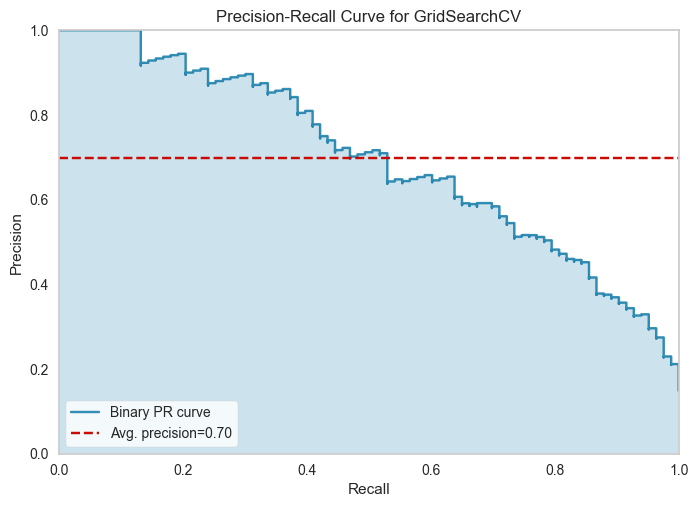

<Axes: title={'center': 'Precision-Recall Curve for GridSearchCV'}, xlabel='Recall', ylabel='Precision'>

In [75]:
visualizer = PrecisionRecallCurve(grid_search_ridge, classes=['0', '1'])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

- The Precision-Recall curve for the Logistic Regression model with GridSearchCV shows how the precision and recall trade off with each other for different threshold settings.

- The model achieves an average precision of 0.70, which is highlighted by the red dashed line.

- The curve demonstrates that the model maintains high precision for lower recall values, but precision drops significantly as recall increases. This indicates that while the model can accurately identify positive cases at lower thresholds, it tends to classify more false positives as it tries to capture more true positives.

- The overall performance suggests that the model is moderately effective at balancing precision and recall, but there is room for improvement, especially if higher recall is desired without compromising precision excessively.

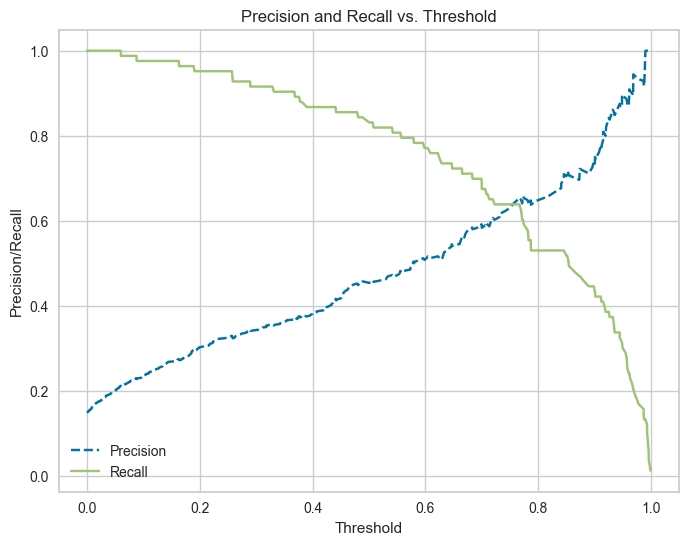

Optimal Threshold: 0.7665783385403565
Accuracy: 0.896
Precision: 0.654
Recall: 0.639
F1 Score: 0.646
AUC-ROC: 0.910


In [76]:
# Assuming y_test are the true labels and y_pred_proba are the predicted probabilities for the positive class
y_pred_proba = grid_search_ridge.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Function to plot precision-recall curve and indicate threshold
def plot_precision_recall_vs_threshold(precision, recall, thresholds):
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precision[:-1], "b--", label="Precision")
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Precision/Recall")
    plt.title("Precision and Recall vs. Threshold")
    plt.legend(loc="best")
    plt.show()

# Plot precision and recall as a function of the threshold
plot_precision_recall_vs_threshold(precision, recall, thresholds)

# Find the threshold that maximizes the F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold: {optimal_threshold}")

# Apply the new threshold to make final predictions
y_pred_new_threshold = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluate the model with the new threshold
accuracy = accuracy_score(y_test, y_pred_new_threshold)
precision_new = precision_score(y_test, y_pred_new_threshold)
recall_new = recall_score(y_test, y_pred_new_threshold)
f1_new = f1_score(y_test, y_pred_new_threshold)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision_new:.3f}")
print(f"Recall: {recall_new:.3f}")
print(f"F1 Score: {f1_new:.3f}")
print(f"AUC-ROC: {auc_roc:.3f}")

- The graph demonstrates that the model maintains high precision at higher thresholds but precision drops significantly as recall increases at lower thresholds. This indicates that while the model can accurately identify positive cases at higher thresholds, it tends to classify more false positives as it tries to capture more true positives at lower thresholds.

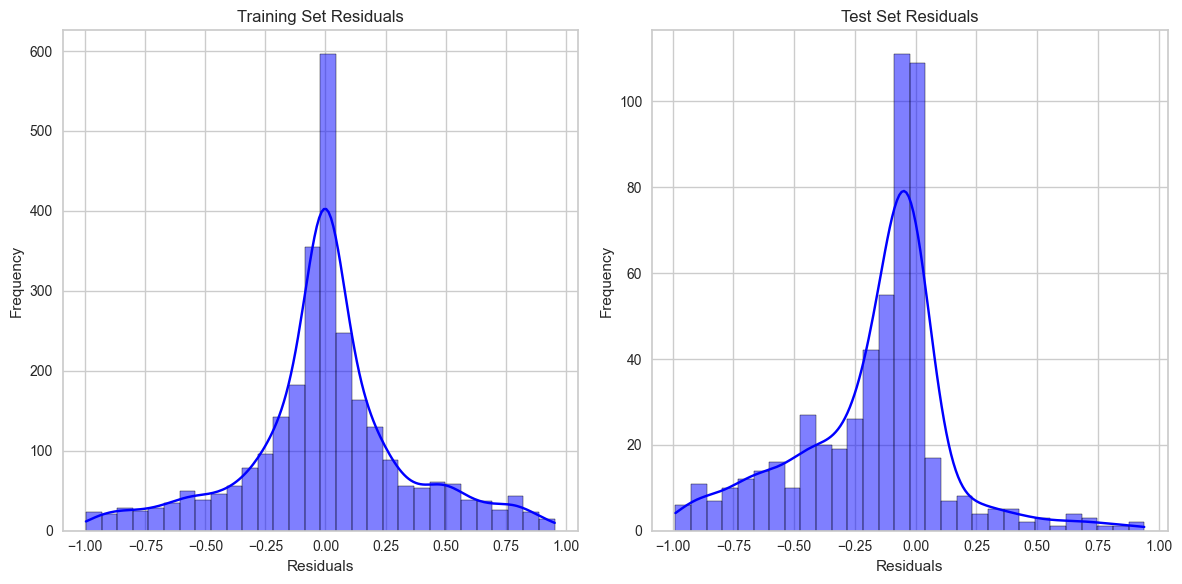

In [77]:
# Calculate residuals for both training and test sets
train_residuals = y_train - y_pred_proba_train_ridge[:, 1]
test_residuals = y_test - y_pred_proba_test_ridge[:, 1]

# Plot residuals
plt.figure(figsize=(12, 6))

# Training residuals
plt.subplot(1, 2, 1)
sns.histplot(train_residuals, kde=True, color='blue', bins=30)
plt.title('Training Set Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Test residuals
plt.subplot(1, 2, 2)
sns.histplot(test_residuals, kde=True, color='blue', bins=30)
plt.title('Test Set Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- Both sets of residuals being centered around zero and approximately normally distributed is a good sign, indicating that the **model performs consistently on both training and test data.**
- Overall, the residuals histograms demonstrate that the model provides unbiased and fairly accurate predictions, though there is some room for improvement in reducing variance and outliers in the test set.